# Part 1: Implement of IRWA
## 1. Implement of QP_solver

In [1]:
import numpy as np 

def QP_solver(A1, A2, b1, b2, g, H): 
    """
    Solves the quadratic programming problem using the Iterative Reweighted Algorithm (IRWA):
        minimize 0.5 * x^T H x + g^T x
        subject to A1 x + b1 = 0
                   A2 x + b2 <= 0

    Parameters:
    - A1, b1: Equality constraints (A1 x + b1 = 0)
    - A2, b2: Inequality constraints (A2 x + b2 <= 0)
    - g, H: Objective function coefficients

    Returns:
    - x: Optimized solution if feasible and convex
    """
    # Combine constraints for unified processing
    A = np.vstack([A1, A2])
    b = np.hstack([b1, b2])
    m_eq = A1.shape[0]  # Number of equality constraints
    m_ineq = A2.shape[0]  # Number of inequality constraints
    m = A.shape[0]

    # Ensure H is positive semi-definite (convexity check)
    H = H.astype(float)  # Convert H to float64 to handle adjustments
    eigenvalues = np.linalg.eigvals(H)
    if np.any(eigenvalues < 0):
        H += np.eye(H.shape[0]) * (1e-5 - np.min(eigenvalues))  # Make H positive semi-definite

    # Initial parameters
    n = H.shape[0]  # Number of variables
    x = np.zeros(n)  # Initialize x as zeros
    epsilon = np.ones(m) * 0.1  # Initial relaxation vector
    eta = 0.9  # Relaxation factor
    gamma = 0.1  # Update criterion
    M1 = 10  # Penalty for equality constraints
    M2 = 1   # Penalty for inequality constraints
    max_iter = 1000
    tol_x = 1e-4
    tol_epsilon = 1e-4

    # IRWA main loop
    for k in range(max_iter):
        # Step 1: Compute weights
        weights = np.zeros(m)
        for i in range(m):
            residual = A[i] @ x + b[i]
            if i < m_eq:  # Equality constraint
                weights[i] = M1 / (residual**2 + epsilon[i]**2)**0.5
            else:  # Inequality constraint
                weights[i] = M2 / (max(residual, 0)**2 + epsilon[i]**2)**0.5

        # Construct weighted matrices
        W = np.diag(weights)
        H_hat = H + A.T @ W @ A
        g_hat = g + A.T @ W @ b

        # Step 2: Solve linear system for x
        try:
            x_new = np.linalg.solve(H_hat, -g_hat)
        except np.linalg.LinAlgError:
            x_new = x  # Retain the previous value of x if matrix is singular

        # Step 3: Update epsilon
        q = A @ (x_new - x)
        r = (1 - W.diagonal()) * (A @ x + b)
        update_condition = np.all(np.abs(q) <= M1 * (r**2 + epsilon**2)**0.5 + gamma)
        epsilon_new = eta * epsilon if update_condition else epsilon

        # Step 4: Check convergence
        if np.linalg.norm(x_new - x) <= tol_x and np.linalg.norm(epsilon_new - epsilon) <= tol_epsilon:
            return x_new

        # Update variables for next iteration
        x = x_new
        epsilon = epsilon_new

    # If max iterations reached, return the last computed x
    return x

For a quadratic programming problem, the matrix $H$ must be **positive semi-definite** for the problem to be convex. The condition `np.any(eigenvalues < 0)` checks if any eigenvalue is negative. If any eigenvalue is negative, the matrix is not positive semi-definite, meaning the problem might be **non-convex**. If the matrix $H$ is found to be non-positive semi-definite (i.e., it has negative eigenvalues), `H += np.eye(H.shape[0]) * (1e-5 - np.min(eigenvalues))` adjustment is made to ensure that $H$ becomes positive semi-definite, where `np.eye(H.shape[0])` creates an identity matrix of the same size as $H$, and `np.min(eigenvalues)` calculates the smallest eigenvalue of $H$. The term `(1e-5 - np.min(eigenvalues))` computes the value needed to add to the diagonal elements of $H$ to make all eigenvalues non-negative. This small adjustment effectively ensures that the matrix $H$ becomes positive semi-definite, thereby ensuring the convexity of the quadratic programming problem.

## Improvements to deal with infeasible and non-convex case

In [2]:
def QP_solver_improve(A1, A2, b1, b2, g, H): 
    # Combine constraints for unified processing
    A = np.vstack([A1, A2])
    b = np.hstack([b1, b2])
    m_eq = A1.shape[0]  # Number of equality constraints
    m_ineq = A2.shape[0]  # Number of inequality constraints
    m = A.shape[0]

    # Ensure H is positive semi-definite (convexity check)
    H = H.astype(float)  # Convert H to float64 to handle adjustments
    eigenvalues = np.linalg.eigvals(H)
    if np.any(eigenvalues < 0):
        print("Warning: The matrix H is not positive semi-definite (non-convex problem).")
        H += np.eye(H.shape[0]) * (1e-5 - np.min(eigenvalues))  # Make H positive semi-definite

    # Initial parameters
    n = H.shape[0]  # Number of variables
    x = np.zeros(n)  # Initialize x as zeros
    epsilon = np.ones(m) * 0.1  # Initial relaxation vector
    eta = 0.9  # Relaxation factor
    gamma = 0.1  # Update criterion
    M1 = 10  # Penalty for equality constraints
    M2 = 1   # Penalty for inequality constraints
    max_iter = 1000
    tol_x = 1e-4
    tol_epsilon = 1e-4

    # IRWA main loop
    for k in range(max_iter):
        # Step 1: Compute weights
        weights = np.zeros(m)
        for i in range(m):
            residual = A[i] @ x + b[i]
            if i < m_eq:  # Equality constraint
                weights[i] = M1 / (residual**2 + epsilon[i]**2)**0.5
            else:  # Inequality constraint
                weights[i] = M2 / (max(residual, 0)**2 + epsilon[i]**2)**0.5

        # Construct weighted matrices
        W = np.diag(weights)
        H_hat = H + A.T @ W @ A
        g_hat = g + A.T @ W @ b

        # Step 2: Solve linear system for x
        try:
            x_new = np.linalg.solve(H_hat, -g_hat)
        except np.linalg.LinAlgError:
            x_new = x  # Retain the previous value of x if matrix is singular

        # Step 3: Update epsilon
        q = A @ (x_new - x)
        r = (1 - W.diagonal()) * (A @ x + b)
        update_condition = np.all(np.abs(q) <= M1 * (r**2 + epsilon**2)**0.5 + gamma)
        epsilon_new = eta * epsilon if update_condition else epsilon

        # Step 4: Check convergence
        if np.linalg.norm(x_new - x) <= tol_x and np.linalg.norm(epsilon_new - epsilon) <= tol_epsilon:
            check_constraints(x, A1, b1, A2, b2)
            return x_new

        # Update variables for next iteration
        x = x_new
        epsilon = epsilon_new

    # If max iterations reached, return the last computed x
    check_constraints(x, A1, b1, A2, b2)
    return x

def check_constraints(x, A1, b1, A2, b2):
    """
    Checks if the solution satisfies the constraints.
    If any constraint is violated, print a message indicating the problem is infeasible.
    """
    # Check equality constraints: A1 x + b1 = 0
    residual_eq = np.abs(A1 @ x + b1)
    if np.any(residual_eq > 1e-4):
        print("Warning: The solution does not satisfy equality constraints (infeasible problem).")

    # Check inequality constraints: A2 x + b2 <= 0
    residual_ineq = A2 @ x + b2
    if np.any(residual_ineq > 1e-4):  # Allow some tolerance for numerical errors
        print("Warning: The solution does not satisfy inequality constraints (infeasible problem).")


After obtaining the solution $x$ from the IRWA algorithm, the constraints are checked using the `check_constraints` function, which performs the equality constraints check and inequality constraints check. The `check_constraints` function is called **after each iteration** and **after convergence**. If the solution violates any of the constraints at any point, the function prints a warning message indicating that the problem is infeasible.

## 2. Some simple tests

In [3]:
if __name__ == "__main__":
    # Define a simple test case
    A1 = np.array([[1, 0], [0, 1]])  # Equality constraints
    b1 = np.array([0, 0])
    A2 = np.array([[1, -1], [-1, 1]])  # Inequality constraints
    b2 = np.array([-1, -1])
    g = np.array([1, 1])  # Linear term in the objective
    H = np.array([[2, 0], [0, 2]])  # Quadratic term (positive definite)
    
    print("Test case: Feasible and convex problem")
    # Call the QP_solver function
    x = QP_solver_improve(A1, A2, b1, b2, g, H)
    
    # Print the result
    print("Optimized solution x:", x)
    
if __name__ == "__main__":
    # Infeasible problem
    A1 = np.array([[1, 1], [1, 1]])  # Contradictory equality constraints
    b1 = np.array([1, 3])  # Inconsistent constraints
    A2 = np.array([[1, -1]])  # Inequality constraint
    b2 = np.array([-1])
    g = np.array([1, 1])  # Linear term
    H = np.array([[2, 0], [0, 2]])  # Positive definite matrix

    print("Test case: Infeasible problem")
    x = QP_solver_improve(A1, A2, b1, b2, g, H)
    print("Solution:", x)
    
if __name__ == "__main__":
    # Non-convex problem
    A1 = np.array([[1, 0], [0, 1]])  # Equality constraints
    b1 = np.array([0, 0])
    A2 = np.array([[1, -1]])  # Inequality constraint
    b2 = np.array([-1])
    g = np.array([1, 1])  # Linear term
    H = np.array([[2, 1], [1, -3]])  # Non-convex matrix (negative eigenvalues)

    print("Test case: Non-convex problem")
    x = QP_solver_improve(A1, A2, b1, b2, g, H)
    print("Solution:", x)

Test case: Feasible and convex problem
Optimized solution x: [-4.66685595e-05 -4.66685595e-05]
Test case: Infeasible problem
Solution: [-0.01925339 -1.01925339]
Test case: Non-convex problem
Solution: [ 5.32262829e-04 -9.99127617e-01]


## 3. Generate function

In [3]:
def generate_feasible_convex_data(n=4, m_eq=2, m_ineq=2, seed=None):
    """
    Randomly generates a feasible and convex quadratic programming problem.

    Parameters:
    - n: Number of variables
    - m_eq: Number of equality constraints
    - m_ineq: Number of inequality constraints
    - seed: Random seed for reproducibility

    Returns:
    - A1, b1: Equality constraint matrices
    - A2, b2: Inequality constraint matrices
    - g, H: Objective function coefficients
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate a positive definite matrix H
    Q = np.random.randn(n, n)
    H = Q.T @ Q + np.eye(n)  # Ensure positive definiteness

    # Generate a random linear term g
    g = np.random.randn(n)

    # Generate random equality constraints (A1 x + b1 = 0)
    A1 = np.random.randn(m_eq, n)
    x_feasible = np.random.randn(n)  # Generate a random feasible point
    b1 = -A1 @ x_feasible

    # Generate random inequality constraints (A2 x + b2 <= 0)
    A2 = np.random.randn(m_ineq, n)
    b2 = -A2 @ x_feasible - np.random.rand(m_ineq)  # Ensure x_feasible satisfies A2 x + b2 <= 0

    return A1, b1, A2, b2, g, H

This function generates a random feasible and convex quadratic programming (QP) problem by randomly creating the objective function coefficients and constraints that satisfy the necessary conditions for convexity and feasibility. $H$ is generated by first creating a random matrix $Q$ with shape $(n, n)$ and then computing $H = Q^TQ + I$, where $I$ is the identity matrix. This ensures that $H$ is **positive definite**.

## 4. Test the generate function

In [4]:
if __name__ == "__main__":
    # Generate a test case
    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=4, m_eq=2, m_ineq=2, seed=42)

    print("Generated data:")
    print("H (Positive definite):")
    print(H)
    print("g (Linear term):")
    print(g)
    print("A1 (Equality constraints):")
    print(A1)
    print("b1 (Equality constants):")
    print(b1)
    print("A2 (Inequality constraints):")
    print(A2)
    print("b2 (Inequality constants):")
    print(b2)

    # Test the QP solver
    x = QP_solver(A1, A2, b1, b2, g, H)
    print("Solution from QP_solver:")
    print(x)

Generated data:
H (Positive definite):
[[ 1.58050469 -0.73151355 -0.24786425  0.65940888]
 [-0.73151355  5.02894983  2.589515    0.43286178]
 [-0.24786425  2.589515    7.10351105  3.38411893]
 [ 0.65940888  0.43286178  3.38411893  4.44164748]]
g (Linear term):
[-1.01283112  0.31424733 -0.90802408 -1.4123037 ]
A1 (Equality constraints):
[[ 1.46564877 -0.2257763   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358  0.37569802]]
b1 (Equality constants):
[ 3.49412997 -1.68307959]
A2 (Inequality constraints):
[[-0.01349722 -1.05771093  0.82254491 -1.22084365]
 [ 0.2088636  -1.95967012 -1.32818605  0.19686124]]
b2 (Inequality constants):
[ 1.47005352 -2.38512489]
Solution from QP_solver:
[-1.00679766 -0.7870228  -0.56764987  1.51451912]


# Part 2: Analyzing the impact of parameter variations
In this part, we choose some parameters like $\gamma$ and $\eta$ to analyze their impact on iteration numbers and the objective function values.

In [5]:
def QP_solver_exp(A1, A2, b1, b2, g, H, eta=0.9, gamma=0.1, M1=10, M2=1, tol=1e-4):
    
    # Combine constraints for unified processing
    A = np.vstack([A1, A2])
    b = np.hstack([b1, b2])
    m_eq = A1.shape[0]  # Number of equality constraints
    m_ineq = A2.shape[0]  # Number of inequality constraints
    m = A.shape[0]

    # Ensure H is positive semi-definite (convexity check)
    H = H.astype(float)  # Convert H to float64 to handle adjustments
    eigenvalues = np.linalg.eigvals(H)
    if np.any(eigenvalues < 0):
        H += np.eye(H.shape[0]) * (1e-5 - np.min(eigenvalues))  # Make H positive semi-definite

    # Initial parameters
    n = H.shape[0]  # Number of variables
    x = np.zeros(n)  # Initialize x as zeros
    epsilon = np.ones(m) * 0.1  # Initial relaxation vectorerion
    max_iter = 1000
    tol_x = tol
    tol_epsilon = tol

    # IRWA main loop
    for k in range(max_iter):
        # Step 1: Compute weights
        weights = np.zeros(m)
        for i in range(m):
            residual = A[i] @ x + b[i]
            if i < m_eq:  # Equality constraint
                weights[i] = M1 / (residual**2 + epsilon[i]**2)**0.5
            else:  # Inequality constraint
                weights[i] = M2 / (max(residual, 0)**2 + epsilon[i]**2)**0.5

        # Construct weighted matrices
        W = np.diag(weights)
        H_hat = H + A.T @ W @ A
        g_hat = g + A.T @ W @ b

        # Step 2: Solve linear system for x
        try:
            x_new = np.linalg.solve(H_hat, -g_hat)
        except np.linalg.LinAlgError:
            x_new = x  # Retain the previous value of x if matrix is singular

        # Step 3: Update epsilon
        q = A @ (x_new - x)
        r = (1 - W.diagonal()) * (A @ x + b)
        update_condition = np.all(np.abs(q) <= M1 * (r**2 + epsilon**2)**0.5 + gamma)
        epsilon_new = eta * epsilon if update_condition else epsilon

        # Step 4: Check convergence
        if np.linalg.norm(x_new - x) <= tol_x and np.linalg.norm(epsilon_new - epsilon) <= tol_epsilon:
            return x_new, k + 1

        # Update variables for next iteration
        x = x_new
        epsilon = epsilon_new

    # If max iterations reached, return the last computed x
    return x, max_iter

## 2.1 Test the influence of $\eta$
### Try different $\eta$
Firstly, we intend to investigate the effect of $\eta$ on the number of iterations and the function values. We control all variables except $\eta$, allowing $\eta$ to vary from 0.5 to 0.95, and plot the curves of $\eta$ versus iterations and $\eta$ versus function values.

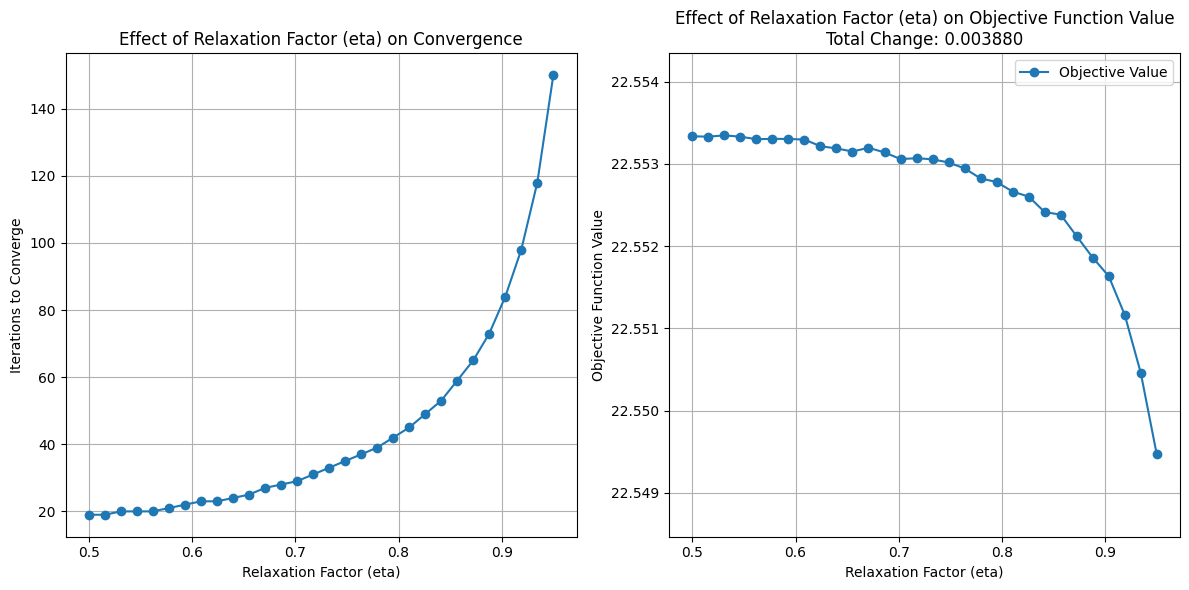

In [6]:
import matplotlib.pyplot as plt

if __name__ == "__main__":

    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=10, m_eq=5, m_ineq=5, seed=42)

    # Test the effect of eta
    eta_values = np.linspace(0.5, 0.95, 30)
    objective_values = []
    iterations = []

    for eta in eta_values:
        x, iter_count = QP_solver_exp(A1, A2, b1, b2, g, H, eta=eta)
        objective_value = 0.5 * x.T @ H @ x + g.T @ x
        objective_values.append(objective_value)
        iterations.append(iter_count)
        
    # Plot results side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot iterations
    axes[0].plot(eta_values, iterations, marker='o')
    axes[0].set_xlabel("Relaxation Factor (eta)")
    axes[0].set_ylabel("Iterations to Converge")
    axes[0].set_title("Effect of Relaxation Factor (eta) on Convergence")
    axes[0].grid(True)

    # Plot objective function values
    axes[1].plot(eta_values, objective_values, marker='o', label='Objective Value')
    axes[1].set_ylim(min(objective_values) - 0.001, max(objective_values) + 0.001)  # Adjust y-axis range
    axes[1].set_xlabel("Relaxation Factor (eta)")
    axes[1].set_ylabel("Objective Function Value")
    change = max(objective_values) - min(objective_values)
    axes[1].set_title(f"Effect of Relaxation Factor (eta) on Objective Function Value\nTotal Change: {change:.6f}")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

From the figure, it can be seen that as $\eta$ increases, the number of iterations of the algorithm rises significantly, and the function values gradually decrease, though the decrease is not substantial.

## 2.2 Test the influence of $\gamma$
### Try different $\gamma$
Next, we examined the effect of $\gamma$ on the number of iterations and the function values. Similar to the study of $\eta$, this time we controlled all variables except $\gamma$, allowing $\gamma$ to vary from 0.01 to 10, and plotted the curves of $\gamma$ versus iterations and $\gamma$ versus function values.

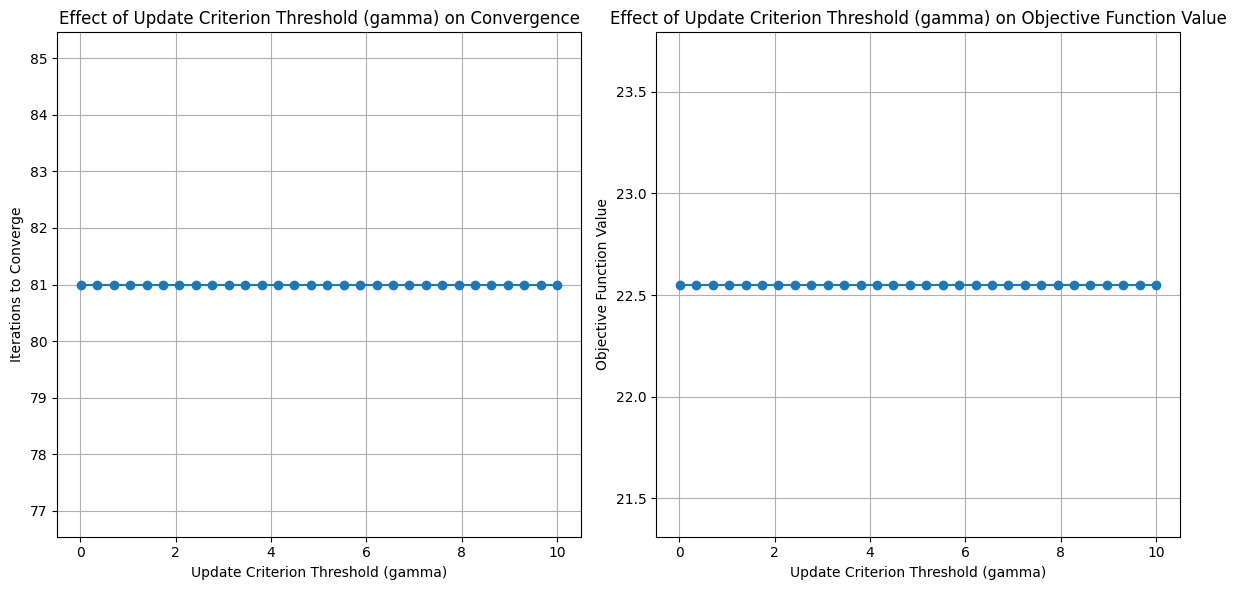

In [7]:
if __name__ == "__main__":

    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=10, m_eq=5, m_ineq=5, seed=42)

    # Test the effect of gamma
    gamma_values = np.linspace(0.01, 10, 30)
    objective_values = []
    iterations = []

    for gamma in gamma_values:
        x, iter_count = QP_solver_exp(A1, A2, b1, b2, g, H, gamma=gamma)
        iterations.append(iter_count)
        objective_value = 0.5 * x.T @ H @ x + g.T @ x
        objective_values.append(objective_value)

    # Plot results side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot iterations
    axes[0].plot(gamma_values, iterations, marker='o')
    axes[0].set_xlabel("Update Criterion Threshold (gamma)")
    axes[0].set_ylabel("Iterations to Converge")
    axes[0].set_title("Effect of Update Criterion Threshold (gamma) on Convergence")
    axes[0].grid(True)

    # Plot objective function values
    axes[1].plot(gamma_values, objective_values, marker='o')
    axes[1].set_xlabel("Update Criterion Threshold (gamma)")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title("Effect of Update Criterion Threshold (gamma) on Objective Function Value")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

From the figure, it can be seen that regardless of how $\gamma$ varies between 0.01 and 10, neither the number of iterations nor the function values of the algorithm change. This indicates that the value of $\gamma$ has little overall impact on the algorithm.

## 2.3 Test the influence of $M_1$ and $M_2$
Next, we examined the effects of $M_1$ and $M_2$ (i.e., the equality constraint penalty coefficient and the inequality constraint penalty coefficient) on the number of iterations and the function values of the algorithm.

### $M_2$ fixed, $M_1$ varying
Firstly, we controlled $M_2$ and kept the other parameters unchanged, allowing $M_1$ to vary from 1 to 200. Then, we plotted the curves of $M_1$ versus the number of iterations and $M_1$ versus the function values.

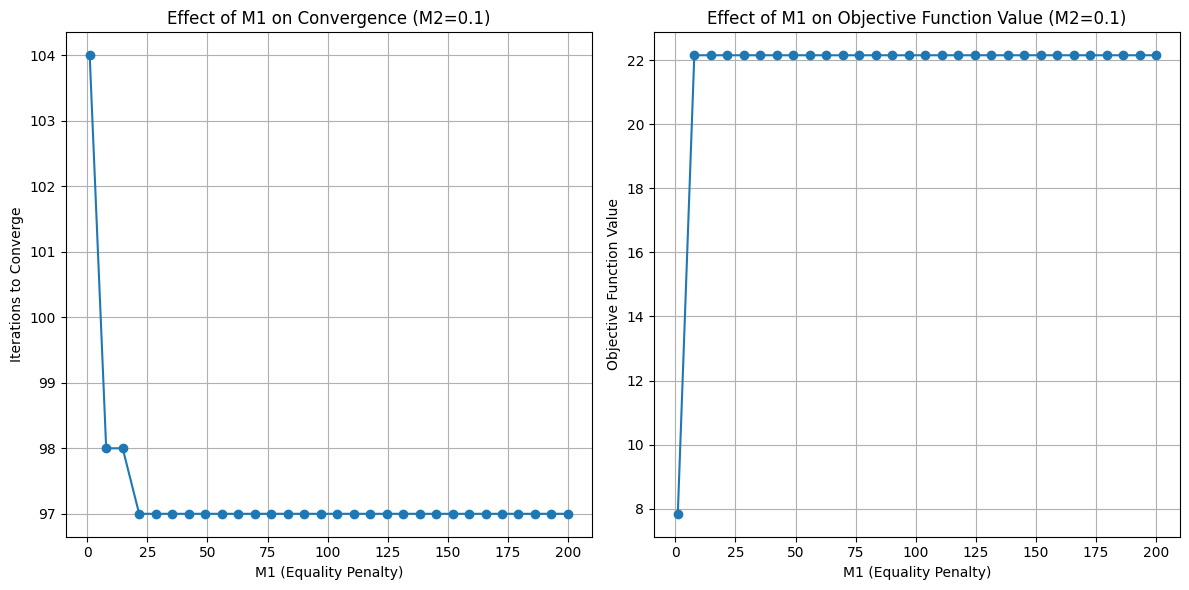

In [8]:
if __name__ == "__main__":

    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=10, m_eq=5, m_ineq=5, seed=42)

    M1_values = np.linspace(1, 200, 30)
    M2_values = np.linspace(0.1, 50 ,30)

    # Case 1: M2 fixed, M1 varying
    fixed_M2 = 0.1
    objective_values_M1 = []
    iterations_M1 = []

    for M1 in M1_values:
        x, iter_count = QP_solver_exp(A1, A2, b1, b2, g, H, M1=M1, M2=fixed_M2)
        objective_value = 0.5 * x.T @ H @ x + g.T @ x
        objective_values_M1.append(objective_value)
        iterations_M1.append(iter_count)

    # Plot M1 varying
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(M1_values, iterations_M1, marker='o')
    axes[0].set_xlabel("M1 (Equality Penalty)")
    axes[0].set_ylabel("Iterations to Converge")
    axes[0].set_title(f"Effect of M1 on Convergence (M2={fixed_M2})")
    axes[0].grid(True)

    axes[1].plot(M1_values, objective_values_M1, marker='o')
    axes[1].set_xlabel("M1 (Equality Penalty)")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title(f"Effect of M1 on Objective Function Value (M2={fixed_M2})")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

From the figure, it can be seen that except when the value of $M_1$ is extremely small (i.e., 1), $M_1$ has almost no effect on the number of iterations and the function values of the algorithm.


### $M_1$ fixed, $M_2$ varying
Secondly, we controlled $M_1$ and kept the other parameters unchanged, allowing $M_2$ to vary from 0.1 to 50. Then, we plotted the curves of $M_2$ versus the number of iterations and $M_2$ versus the function values.

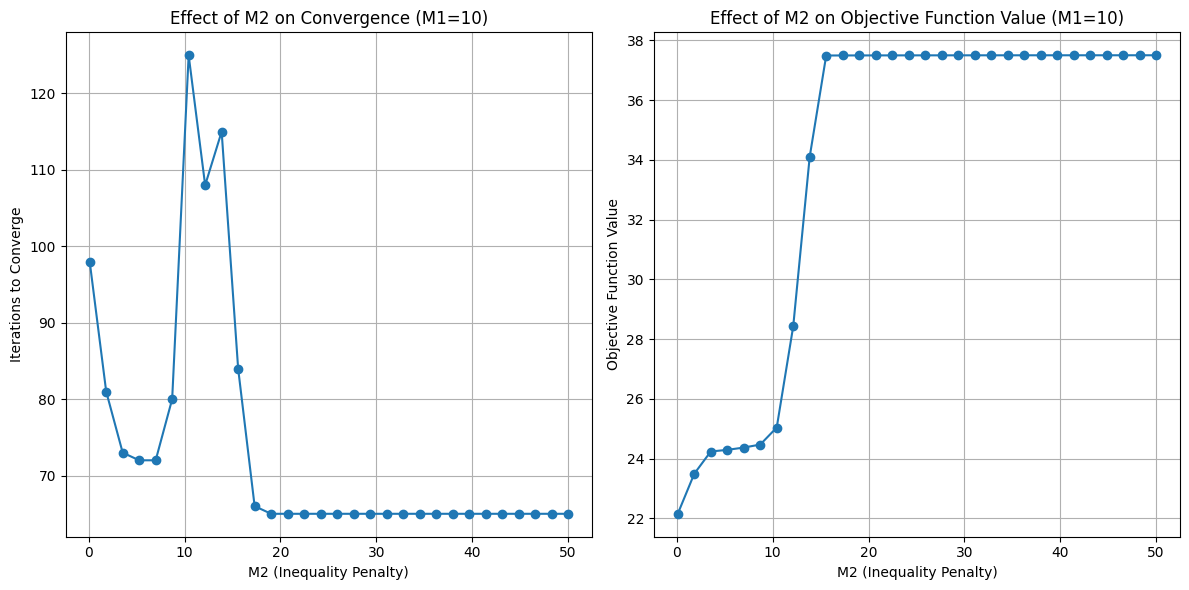

In [9]:
if __name__ == "__main__":

    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=10, m_eq=5, m_ineq=5, seed=42)

    M1_values = np.linspace(1, 200, 30)
    M2_values = np.linspace(0.1, 50 ,30)

    # Case 1: M1 fixed, M2 varying
    fixed_M1 = 10
    objective_values_M2 = []
    iterations_M2 = []

    for M2 in M2_values:
        x, iter_count = QP_solver_exp(A1, A2, b1, b2, g, H, M1=fixed_M1, M2=M2)
        objective_value = 0.5 * x.T @ H @ x + g.T @ x
        objective_values_M2.append(objective_value)
        iterations_M2.append(iter_count)

    # Plot M2 varying
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(M2_values, iterations_M2, marker='o')
    axes[0].set_xlabel("M2 (Inequality Penalty)")
    axes[0].set_ylabel("Iterations to Converge")
    axes[0].set_title(f"Effect of M2 on Convergence (M1={fixed_M1})")
    axes[0].grid(True)

    axes[1].plot(M2_values, objective_values_M2, marker='o')
    axes[1].set_xlabel("M2 (Inequality Penalty)")
    axes[1].set_ylabel("Objective Function Value")
    axes[1].set_title(f"Effect of M2 on Objective Function Value (M1={fixed_M1})")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


From the figure, it can be seen that as $M_2$ gradually increases, the number of iterations of the algorithm exhibits significant fluctuations, but overall still shows a decreasing trend. This indicates that increasing $M_2$ can accelerate the convergence speed of the algorithm. The function values also increase with the rise of $M_2$ and eventually stabilize.

### $M_1$, $M_2$ varying
Finally, we selected several combinations of $M_1$ and $M_2$ and, while keeping the other variables unchanged, studied the convergence of the algorithm by varying these combinations. We used the values of $M_1$ and $M_2$ as the horizontal and vertical axes, respectively, and represented the number of iterations with the color of the points. The color gradient from light to dark indicates that the algorithm requires more iterations to converge.

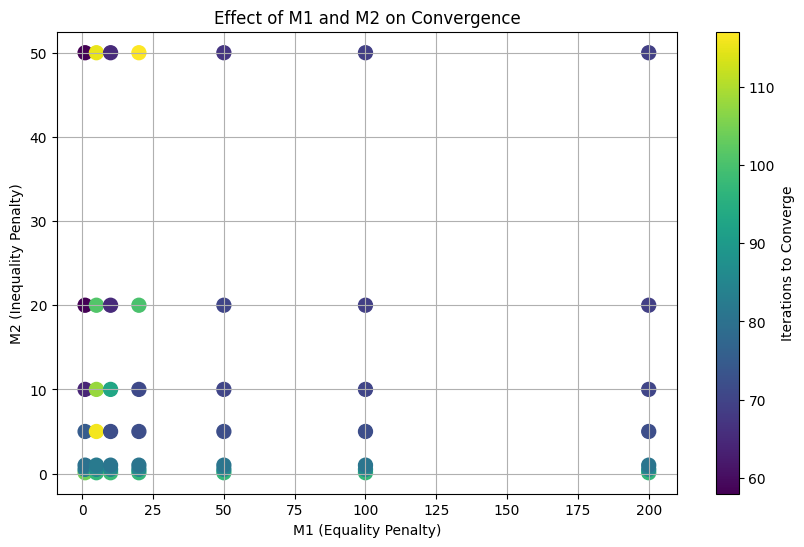

In [10]:
if __name__ == "__main__":

    A1, b1, A2, b2, g, H = generate_feasible_convex_data(n=10, m_eq=5, m_ineq=5, seed=42)

    # Test the effect of M1 and M2
    M1_values = [1, 5, 10, 20, 50, 100, 200]
    M2_values = [0.1, 0.5, 1, 5, 10, 20, 50]
    results = []
    

    for M1 in M1_values:
        for M2 in M2_values:
            _, iter_count = QP_solver_exp(A1, A2, b1, b2, g, H, M1=M1, M2=M2)
            results.append((M1, M2, iter_count))

    # Plot results
    M1_vals, M2_vals, iter_counts = zip(*results)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(M1_vals, M2_vals, c=iter_counts, cmap='viridis', s=100)
    plt.colorbar(scatter, label="Iterations to Converge")
    plt.xlabel("M1 (Equality Penalty)")
    plt.ylabel("M2 (Inequality Penalty)")
    plt.title("Effect of M1 and M2 on Convergence")
    plt.grid(True)
    plt.show()

## Part 3: Analyzing the impact of tolerance
### 3.1 Generate function from the paper

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for the experiment
def generate_experiment_data(n, m_eq, m_ineq, seed=None):
    """
    Generates a random quadratic programming problem as described in the IRWA paper.

    Parameters:
    - n: Number of variables
    - m_eq: Number of equality constraints
    - m_ineq: Number of inequality constraints
    - seed: Random seed for reproducibility

    Returns:
    - A1, b1, A2, b2, g, H: Problem data
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate A (m_eq + m_ineq rows, n columns)
    means = np.random.uniform(1, 10, size=(m_eq + m_ineq))
    variances = np.random.uniform(1, 10, size=(m_eq + m_ineq))
    A = np.vstack([
        np.random.normal(mean, var**0.5, size=n) for mean, var in zip(means, variances)
    ])

    # Split A into equality and inequality parts
    A1 = A[:m_eq]
    A2 = A[m_eq:]

    # Generate b1 and b2
    b1_means = np.random.uniform(-100, 100, size=m_eq)
    b1_vars = np.random.uniform(1, 100, size=m_eq)
    b1 = np.array([np.random.normal(mean, var**0.5) for mean, var in zip(b1_means, b1_vars)])

    b2_means = np.random.uniform(-100, 100, size=m_ineq)
    b2_vars = np.random.uniform(1, 100, size=m_ineq)
    b2 = np.array([np.random.normal(mean, var**0.5) for mean, var in zip(b2_means, b2_vars)])

    # Generate g
    g = np.random.randn(n)

    # Generate H = 0.1I + L^T L
    L = np.random.normal(1, 2, size=(n, n))
    H = 0.1 * np.eye(n) + L.T @ L

    return A1, b1, A2, b2, g, H

In this experiment, we randomly generated 500 instances. For each, we generated $A\in R^{12\times 20}$. The matrix $A$ is generated for both equality and inequality constraints. It has `m_eq + m_ineq rows` (for the number of constraints) and `n` columns (for the number of variables). Here we let `m_eq = 6`, `m_ineq = 6` and `n = 20`. For each constraint (row), random means and variances are drawn from a uniform distribution between 1 and 10. For each constraint, the matrix $A$ is populated by generating random normal variables using `np.random.normal(mean, var**0.5)`, where mean and var come from the previously generated means and variances. The `var**0.5` is the standard deviation of the normal distribution. The first `m_eq` rows of the matrix $A$ are assigned to the equality constraint matrix $A_1$, and the remaining rows (i.e., the inequality constraints) are assigned to $A_2$.

$b_1$ represents the right-hand side of the equality constraints. The means and variances for $b_1$ are randomly drawn from uniform distributions with values between -100 and 100 for the means, and between 1 and 100 for the variances. Each $b_1$ value is generated using a normal distribution, where the standard deviation is determined by `var**0.5`. $b_2$ represents the right-hand side of the inequality constraints. Similar to $b_1$, the means and variances for $b_2$ are randomly drawn, and each $b_2$ value is generated using a normal distribution.

The vector $g$ represents the linear coefficients in the objective function. It is generated randomly from a normal distribution with mean 0 and variance 1. $L$ is an $n\cdot n$ matrix of random values drawn from a normal distribution with mean 1 and standard deviation 2. $H$ is generated using the formula $H=0.1I+L^TL$, where $I$ is the identity matrix. This ensures that $H$ is **positive semi-definite**, which guarantees the convexity of the objective function.

### 3.2 Try different `tol`

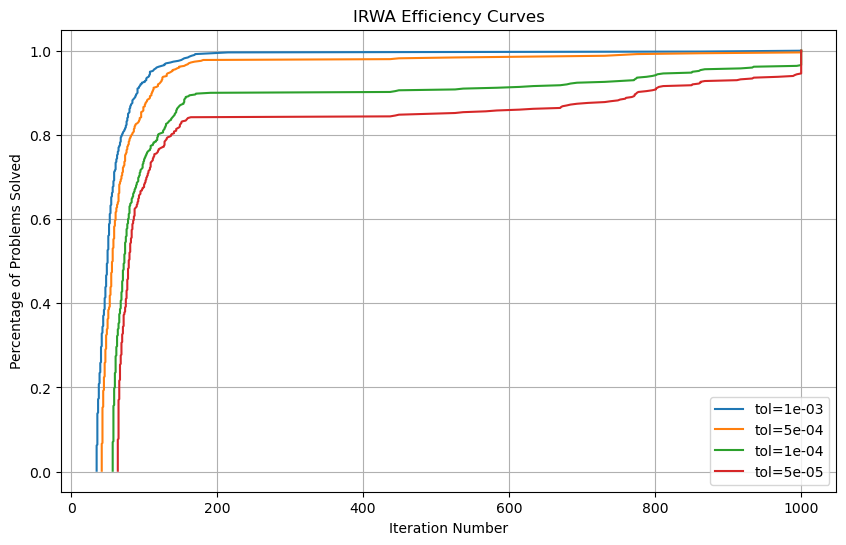

In [3]:
# Implement the QP_solver function based on IRWA
def QP_solver(A1, A2, b1, b2, g, H, tol_x=1e-4, tol_epsilon=1e-4): 
    # Combine constraints for unified processing
    A = np.vstack([A1, A2])
    b = np.hstack([b1, b2])
    m_eq = A1.shape[0]  # Number of equality constraints
    m_ineq = A2.shape[0]  # Number of inequality constraints
    m = A.shape[0]

    # Ensure H is positive semi-definite (convexity check)
    H = H.astype(float)  # Convert H to float64 to handle adjustments
    eigenvalues = np.linalg.eigvals(H)
    if np.any(eigenvalues < 0):
        H += np.eye(H.shape[0]) * (1e-5 - np.min(eigenvalues))  # Make H positive semi-definite

    # Initial parameters
    n = H.shape[0]  # Number of variables
    x = np.zeros(n)  # Initialize x as zeros
    epsilon = np.ones(m) * 0.1  # Initial relaxation vector
    eta = 0.9  # Relaxation factor
    gamma = 1 / 6  # Update criterion
    M1 = 10  # Penalty for equality constraints
    M2 = 1   # Penalty for inequality constraints
    max_iter = 1000

    # IRWA main loop
    for k in range(max_iter):
        # Step 1: Compute weights
        weights = np.zeros(m)
        for i in range(m):
            residual = A[i] @ x + b[i]
            if i < m_eq:  # Equality constraint
                weights[i] = M1 / (residual**2 + epsilon[i]**2)**0.5
            else:  # Inequality constraint
                weights[i] = M2 / (max(residual, 0)**2 + epsilon[i]**2)**0.5

        # Construct weighted matrices
        W = np.diag(weights)
        H_hat = H + A.T @ W @ A
        g_hat = g + A.T @ W @ b

        # Step 2: Solve linear system for x
        try:
            x_new = np.linalg.solve(H_hat, -g_hat)
        except np.linalg.LinAlgError:
            x_new = x  # Retain the previous value of x if matrix is singular

        # Step 3: Update epsilon
        q = A @ (x_new - x)
        r = (1 - W.diagonal()) * (A @ x + b)
        update_condition = np.all(np.abs(q) <= M1 * (r**2 + epsilon**2)**0.5 + gamma)
        epsilon_new = eta * epsilon if update_condition else epsilon

        # Step 4: Check convergence
        if np.linalg.norm(x_new - x) <= tol_x and np.linalg.norm(epsilon_new - epsilon) <= tol_epsilon:
            return x_new, k + 1

        # Update variables for next iteration
        x = x_new
        epsilon = epsilon_new

    # If max iterations reached, return the last computed x
    return x, max_iter


# Run the experiment
def run_experiment():
    n, m_eq, m_ineq = 20, 6, 6
    num_problems = 500

    tol_values = [1e-3, 5e-4, 1e-4, 5e-5]
    results = {tol: [] for tol in tol_values}
    
    for i in range(num_problems):
        # Generate problem data
        A1, b1, A2, b2, g, H = generate_experiment_data(n, m_eq, m_ineq, seed=i)

        for tol in tol_values:
            _, iter_num = QP_solver(A1, A2, b1, b2, g, H, tol_x=tol, tol_epsilon=tol)
            results[tol].append(iter_num)

    # Plot efficiency curves
    plt.figure(figsize=(10, 6))
    for tol, iter_num in results.items():
        iter_num = np.array(iter_num)
        solved_percentage = np.cumsum(np.ones_like(iter_num)) / num_problems
        sorted_indices = np.argsort(iter_num)
        plt.plot(iter_num[sorted_indices], solved_percentage, label=f"tol={tol:.0e}")

    plt.xlabel("Iteration Number")
    plt.ylabel("Percentage of Problems Solved")
    plt.title("IRWA Efficiency Curves")
    plt.legend()
    plt.grid()
    plt.show()

# Run the experiment
if __name__ == "__main__":
    run_experiment()


From the plot given above, it's easy to learn that when `tol` gets smaller, the efficiency of the algorithm gets lower.